# Lines in the Poincaré Disk Model of Hyperbolic Geometry


Someone I follow on social media made [this cool graphic](https://society6.com/product/a-hypergeometric-transformation_print#s6-3862893p4a1v45). I wondered how it would look if she used arced lines like in the Poincaré disk. She responded that doing computer graphics with hyperbolic geometry is kind of a pain in the butt. This workbook is to respond to that: affirmatively, because when I actually sat down and started working it out, it did become kind of a pain. It is possible, though I wouldn't want to try to do it in LaTeX (which is what she was using)<sup>1</sup>. Using complex numbers for the calculations made it a bit easier. 

Let's load `numpy` and `matplotlib` and do all the other initialization stuff.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

np.seterr(divide='ignore')#so it's not constantly yelling at us for dividing by zero

{'divide': 'warn', 'invalid': 'warn', 'over': 'warn', 'under': 'ignore'}

Let's define the disk as $\{z \in \mathbb{C} : \left|z\right| \leq 1\}$. Points on the unit circle $\left|z\right| = 1$ are called *ideal points* or *points at infinity*. The "lines" (geodesics) of the Poincaré disk are all circular arcs that meet the unit circle at right angles, i.e. all circles orthogonal to the unit circle, as well as all diameters of the disk. (It can be convenient to consider those lines to be circles with infinite center and radius.)

Here's a basic task in geometry: draw a line between two points $a$ and $b$. On the Poincaré disk, that means we need a circle that is orthogonal to the unit circle and passes through $a$ and $b$. Most texts on hyperbolic geometry tell you how to do this, but they give a compass and straightedge construction, which isn't very useful if you're trying to plot it on a computer screen. You would rather have a formula for the (euclidean) center and the radius, and then you can tell your software, "Hey, go plot a circle."

You can translate the steps of the compass and straightedge construction into analytic complex formulas. I'm not going to torture you with the derivation, but the formula for the center of the circle is fairly nice<sup>2</sup>:
$$
q = \frac{a\left(1+\left|b\right|^2\right)-b\left(1+\left|a\right|^2\right)}{a\overline b-\overline a b}
$$
$q$ is undefined when $a\overline b-\overline a b = 0$. That is true iff $a$ and $b$ both lie on a diameter, in which case the line is just a straight Euclidean line. If we want to confuse people, we can refer to the line through zero that the diameter is part of as a circle of infinite radius. In effect, if $\left|q\right|$ is really big, the arc is instinguishable from a line. We'll use this fact later to avoid computational issues when $a$ and $b$ are very close to sharing a diameter.

The radius is just $r = \left|a-q\right| = \left|b-q\right|$. Let's create a function that gives us the center and radius from the two points $a$ and $b$.

In [2]:
def ortho_euc_circle(a, b):
    """ Gives the center and radius of the circle that passes through 
    a and b and is also orthogonal to the unit circle."""
    numerator = a*(1+abs(b)**2)-b*(1+abs(a)**2)
    denominator= a*b.conjugate()-a.conjugate()*b 
    center = numerator/denominator
    radius = np.abs(a-center)            
    return center, radius

Let's pick a couple points and try it out.

In [3]:
a = 0.5
b = 0.5j
pts = np.array([a, b])

center, radius = ortho_euc_circle(a,b)

In [4]:
#a couple functions for things we'll have to do over and over again
def plot_circle_arc(center=0, radius=1, lower_lim=0, upper_lim=2*np.pi, num=360, color='k'):
    t = np.linspace(lower_lim, upper_lim, num=360)
    unitcircle = radius*np.exp(1j*t)+center
    plt.plot(unitcircle.real, unitcircle.imag,c=color)
    
def initialize_plot():
    fig = plt.figure(figsize=(5,5))
    #unit circle
    plot_circle_arc()
    plt.axis('off')

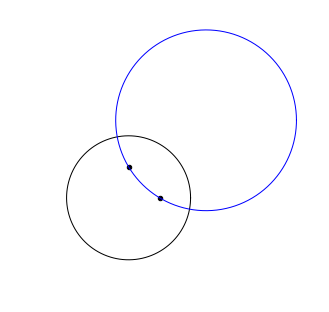

In [5]:
initialize_plot()
plot_circle_arc(center, radius, color='b')
plt.scatter(np.real(pts), np.imag(pts), c='k')
plt.show() 

Well, we have our circle... but we have *all* of the circle, including the part outside of the disk! What if we just want the segment between the two points? Well, We can determine the angle from the center of the blue circle to the two points, and just plot that. We just need to make sure our angles are for the smaller arc of the circle, not the larger one.

In [6]:
def smaller_arc(arc_angle):
    result = arc_angle.copy()
    if abs(result[0]-result[1]) > np.pi:
        if result[0]<result[1]:
            result[0] += 2*np.pi
        else:
            result[1] += 2*np.pi
    return np.sort(result)
    
def arc_angle(pts, center):
    angles = np.angle(pts-center)
    return smaller_arc(angles)

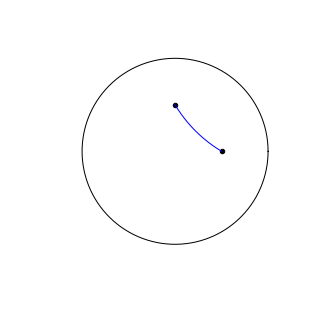

In [7]:
angle = arc_angle(pts, center)

initialize_plot()
#"line" between a and b
plot_circle_arc(center, radius, lower_lim=angle[0], upper_lim=angle[1], color='b')
plt.scatter(np.real(pts), np.imag(pts), c='k')
plt.show() 

Ok, but what if we want the line to extend out to the limit points? We could just calculate the whole circle and get rid of the part that's outside the unit circle. But we wind up doing a lot of processing just to throw it away, and unless we use a bajillion steps when we plot the circle, there tends to be a gap where the two circles meet. The straighter the line, the worse it is.

Instead, we'll calculate the angle from the center of the orthogonal circle where the two circles intersect. We can do this by <s>abusing Wolfram Alpha</s> solving for the system of equations created by the two circles. Again, I'm not going to torture you with the derivation, but the formula is:
$$
\theta = 2 \Arctan\left(\frac{2 r \Im \left(q\right) \pm \sqrt{4 r^2 - \left(1-\left|q\right|^2+r^2\right)^2}}
{1 + 2r \Re \left(q\right) -r^2  - \left|q\right|^2}\right)
$$
Note that these are the angles with respect to q, not the origin. The corresponding limit points on the disk are $ z = r \operatorname{exp} \left(i\theta\right) + q$. Let's try this formula...

In [8]:
def ext_angle(center, radius):
    absc_sq = abs(center)**2
    denom = 1 + 2*radius*center.real- radius**2 -absc_sq
    numer_1 = 2*radius*center.imag        
    numer_2 = np.sqrt(4*radius**2-(1-absc_sq+radius**2)**2)
    angle = 2*np.arctan((numer_1 +np.array([-1,1])*numer_2)/denom)
    return smaller_arc(angle)

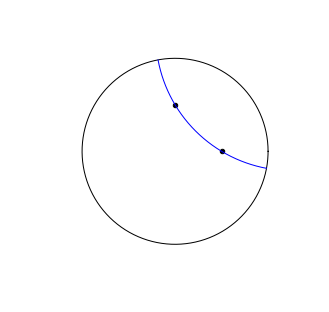

In [9]:
angle = ext_angle(center, radius)

initialize_plot()
#"line" between a and b
plot_circle_arc(center=center, radius=radius, lower_lim=angle[0], upper_lim=angle[1], color='b')
plt.scatter(np.real(pts), np.imag(pts), c='k')
plt.show() 

Much better! All we had to do was, well, derive a really ugly formula.

In real life, we'll need handling for the case where the points line on a diameter. Here's a function that does most of the goofy handling.

In [10]:
def plot_hyp_line(a,b,extend=True, straighten = 1E10): 
    """Plots hyperbolic lines.
    Input: 
        a, b: Points to plot the line between.
        extend: Whether to extend the lines to the limit points.
        straighten: If abs(center) winds up being above this value, plot a straight line instead
    """
    pts = np.array([a,b])
    center, radius = ortho_euc_circle(a, b)
    absc = abs(center)
    if absc < straighten:#plot a circular arc
        if extend:
            angle = ext_angle(center, radius)
            plot_circle_arc(center, radius, lower_lim=angle[0], upper_lim=angle[1], color='r')
        angle = arc_angle(pts, center)
        plot_circle_arc(center, radius, lower_lim=angle[0], upper_lim=angle[1], color='b')
    else: #plot a straight line instead
        if extend and (a != 0 or b != 0):
            #normalize the points so they're on the unit circle
            anorm = a/abs(a)
            bnorm = b/abs(b)
            #unless one is zero, in which case use the mirror image of the other one. 
            #if both are zero the line is degenerate, so don't worry about it
            if a == 0:
                anorm = -bnorm
            elif b == 0:
                bnorm = -anorm 
            plt.plot([a.real, b.real], [a.imag, b.imag], c='r')
        plt.plot(pts.real, pts.imag, c='b')

Let's test it out on a representitive set of points.

In [13]:
n=7

#random points on the unit disk
pts = (np.random.uniform(0,1,size=n)*
        np.exp(2j*np.random.uniform(0,np.pi,size=n)))

#move two points to the unit circle
pts[:2] = pts[:2]/abs(pts[:2])
#put one point on a diameter with another one
pts[-1] = -pts[0]*np.random.uniform(0,1)

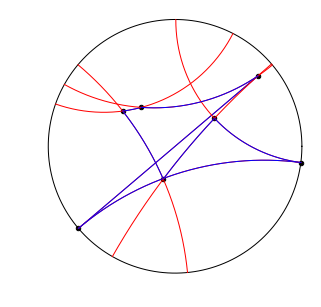

In [14]:
initialize_plot()
axes = plt.gca()
axes.set_xlim([-1.1,1.1])
axes.set_ylim([-1.1,1.1])

for i in range(n):
    plot_hyp_line(pts[i-1],pts[i])
plt.scatter(np.real(pts), np.imag(pts), c='k')
plt.show() 

<sup>1</sup> When I actually tried to recreate the graphic using arced lines, it just looked like a mess, so I wound up doing all this work for nothing, but c'est la vie.

<sup>2</sup> This formula isn't specific to hyperbolic geometry. $a$ and $b$ can be outside the circle and the formula still gives the center of the orthogonal circle.